In [ ]:
'''
The purpose of this exercise is to explore data provided by Yelp, the reviewing engine.  The businesses dataset used here contains information about businesses reviewed on yelp.
I employ a number of machine learning and statistical prediction methods in order to identify attributes of a restaurant that can help predict it's rating.  This exercise
is NOT intended to 
'''

In [2]:

## Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns
import os
import warnings

In [3]:
# Jupyter setup to expand cell display to 100% width on your screen (optional), and print more columns and ignore WARNINGS
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
## Settings
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

In [4]:
## Look at businesses first
path = os.path.expanduser('/Users/mmoesta/Documents/DA_Training/yelp_data_analysis/dataset/csv/')
business_df = pd.read_csv(path + 'business.csv')
print('businesses done')
##Setting indices
business_df.set_index('business_id',inplace = True)

businesses done


In [5]:
## Looking only @ restaurants
restaurants = business_df['categories'].str.contains('Restaurants')
food = business_df['categories'].str.contains('Food')
restfood_df=business_df[restaurants & food]

In [6]:
## Manual categories to remove
categoriesToRemove = ['Grocery','Drugstores','Convenience Stores','Beauty & Spas','Photography Stores & Services',
                      'Cosmetics & Beauty Supply','Discount Store','Fashion','Department Stores','Gas Stations',
                      'Automotive','Music & Video','Event Planning & Services','Mobile Phones','Health & Medical',
                      'Weight Loss Centers','Home & Garden','Kitchen & Bath','Jewelry',"Children's Clothing",
                      'Accessories','Home Decor','Bus Tours','Auto Glass Services','Auto Detailing',
                      'Oil Change Stations', 'Auto Repair','Body Shops','Car Window Tinting','Car Wash',
                      'Gluten-Free','Fitness & Instruction','Nurseries & Gardening','Wedding Planning',
                      'Embroidery & Crochet','Dance Schools','Performing Arts',
                      'Wholesale Stores','Tobacco Shops','Nutritionists','Hobby Shops','Pet Services',
                      'Electronics','Plumbing','Gyms','Yoga','Walking Tours','Toy Stores','Pet Stores',
                      'Pet Groomers','Vape Shops','Head Shops',
                      'Souvenir Shops','Pharmacy','Appliances & Repair','Wholesalers','Party Equipment Rentals',
                      'Tattoo','Funeral Services & Cemeteries','Sporting Goods','Dog Walkers',
                      'Pet Boarding/Pet Sitting','Scavenger Hunts','Contractors','Trainers', 
                      'Customized Merchandise', 'Dry Cleaning & Laundry', 'Art Galleries'
                      'Tax Law', 'Bankruptcy Law', 'Tax Services', 'Estate Planning Law', 
                      'Business Consulting', 'Lawyers', 'Pet Adoption', 'Escape Games', 
                      'Animal Shelters', 'Commercial Real Estate', 'Real Estate Agents', 
                      'Real Estate Services', 'Home Inspectors']

'''I think that this removes an entire row if one of the categories in the row contains a value in categoriesToRemove
will have to revisit
''' 
restfood_df = restfood_df[-restfood_df['categories'].isin(categoriesToRemove)]

In [7]:
## Function to expand attributes and categories columns into dummy columns.  Credit - nick-morgan
#create_attributes

#takes a dataframe as an input, as well as a list of columns that are dictionaries
#takes each column that is a dictionary, and expands it into a series of dummy columns

def create_attributes(df, dictList):
    
    for dictionaryColumn in dictList:
        
        #the attributes column is a string of dictionaries, so one extra step is taken to convert
        if dictionaryColumn == 'attributes':
            expandedColumns = df[dictionaryColumn].map(eval).apply(pd.Series)
        else:
            expandedColumns = df[dictionaryColumn].apply(pd.Series)
        
        df = pd.concat([df.drop(dictionaryColumn,axis=1), 
                   expandedColumns]
                  ,axis=1)
        
        #df.fillna(value='{}',inplace=True)
        if df.index.name != 'business_id':
            df.set_index('business_id', inplace=True)
    return df

## Function to expand categories.  Credit - nick-morgan
def expand_categories(df, cat_var, key):
    all_cats = df[cat_var].str.cat(sep=', ')
    all_cats = all_cats.replace('[', '')
    all_cats = all_cats.replace(']', '')
    all_cats = all_cats.replace("\'","")
    all_cats = all_cats.replace('"','')
    all_cats_list = all_cats.split(', ')
    unique_cats = list(set(all_cats_list))
    unique_cats.remove('Restaurants')
    unique_cats.remove('Food')
    df.reset_index(inplace=True)
    df_cats = pd.DataFrame(index=df[key], columns=unique_cats, data=False)
    df_out = df.merge(df_cats, how='left', left_on=key, right_index=True)
    for cat in unique_cats:
        df_out[cat] = df_out[cat_var].str.contains(cat)
    if df.index.name != 'business_id':
        df_out.set_index('business_id', inplace=True)
    return df_out 

In [8]:
attributes_df= create_attributes(restfood_df, ['attributes'])

In [9]:
categories_df = expand_categories(restfood_df, 'categories', 'business_id')

In [10]:
cols_to_use = categories_df.columns.difference(attributes_df.columns)
result_df = attributes_df.merge(categories_df[cols_to_use], how = 'inner', left_index =True, right_index = True, copy = False)

In [11]:
result_df.drop(['categories','attributes','address','city','name','neighborhood','postal_code'],
                                  axis=1,inplace=True)
att_to_expand = []
for i in range(len(result_df.columns.values)):
    if result_df[result_df.columns.values[i]].dtype == 'O':
            att_to_expand.append(result_df.columns.values[i])         
#print(att_to_expand)

In [12]:
expanded_rest_df = create_attributes(result_df,att_to_expand)

In [14]:
## Getting rid of all restaurants that are no longer open
expanded_rest_df= expanded_rest_df[expanded_rest_df['is_open'] != 0]
expanded_rest_df['is_open'].value_counts()

1    12867
Name: is_open, dtype: int64

In [15]:
## Fill NA values with zeroes
expanded_rest_df.fillna(value = 0, inplace =True)

In [16]:
## Drop any unnamed columns:  This means they didn't have a name when columns were expanded, would not be useful to our analysis
unnamed_cols = [0] * 40
expanded_rest_df.drop(labels = unnamed_cols,axis=1,inplace=True)

In [17]:
## Transforming DataFrame to arrays for sklearn analysis
y = expanded_rest_df['stars']
X = expanded_rest_df.drop(labels=['stars','Unnamed: 0', 'is_open','latitude','longitude','review_count'], axis=1)

In [18]:
## We can use PCA to determine problem complexity, maybe reduce dimensionality.
from sklearn.decomposition import PCA

In [19]:
pca = PCA()
pca.fit(X,y)
print('Variance explained by first 20 components:  ' + str(pca.explained_variance_ratio_[:20]))
print('Total  % variance explained by first 20 components:  ' + str(sum(pca.explained_variance_ratio_[:20])))

Variance explained by first 20 components:  [ 0.13453425  0.08982583  0.06336562  0.04400319  0.03762024  0.03580554
  0.03384686  0.02448971  0.02333514  0.02014179  0.01917077  0.01755161
  0.01664156  0.01632004  0.01537028  0.01507873  0.014052    0.01315465
  0.0127286   0.01246621]
Total  % variance explained by first 20 components:  0.65950263603


In [20]:
## Basic random forest classifier.  It might be funky with so many dimensions, we will have to see.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils

In [21]:
## Have to encode the predictor variable to binary in order to run RF
lab_enc = preprocessing.LabelEncoder()
y_encoded = lab_enc.fit_transform(y)

In [22]:
X_mat = X.as_matrix()
X_train,X_test,y_train,y_test = train_test_split(X_mat,y_encoded, test_size=0.3)
clf = RandomForestClassifier()

In [25]:
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
## Wow, looks pretty good!
clf.score(X_train,y_train)

0.75105485232067515

In [27]:
## Nevermind, some serious overfitting going on here.  Model is detecting patterns that don't exist in test data.
clf.score(X_test,y_test)

0.25097125097125095

The most important features are:  ['RestaurantsPriceRange2' 'Sandwiches' 'Fast Food' 'lot' 'casual'
 'breakfast' 'lunch' 'street' 'Breakfast & Brunch' 'Coffee & Tea' 'dinner'
 'Burgers' 'brunch' 'Desserts' 'dessert']


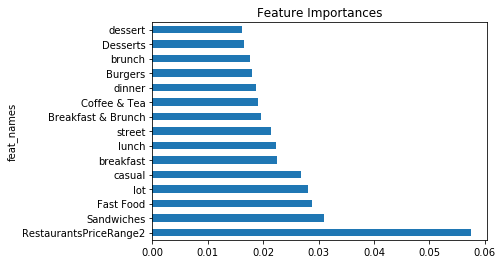

In [28]:
## Okay, so we won't use random forest here, but maybe we can look @ feature importances for some clues
feat_index = list(np.where(clf.feature_importances_ > .015)[0])
feat_vals = clf.feature_importances_[feat_index]
feat_names = X.columns.values[feat_index]
clf_df = pd.DataFrame({
    'feat_names': feat_names,
    'feat_index':feat_index,
    'feat_vals':feat_vals
})
clf_df.sort_values(by="feat_vals",ascending=False,inplace=True)
print('The most important features are:  ' + str(clf_df['feat_names'].values))
clf_df.set_index('feat_names',inplace=True)
class_graph = (clf_df['feat_vals']
 .plot.barh()
 .set_title('Feature Importances')
)
plt.show()

In [29]:
## Maybe if we try the random forest regressor...
from sklearn.ensemble import RandomForestRegressor

In [30]:
regr = RandomForestRegressor()
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [31]:
print('Score of regressor on training:  ' + str(regr.score(X_train,y_train)))
## Still pretty bad
print('Score of regressor on test:  ' + str(regr.score(X_test,y_test)))

Score of regressor on training:  0.674564018648
Score of regressor on test:  0.259506751969


The most important features are:  ['Fast Food' 'lunch' 'RestaurantsPriceRange2' 'Burgers' 'casual'
 'Sandwiches' 'lot' 'street' 'breakfast' 'Chicken Wings' 'Coffee & Tea'
 'Breakfast & Brunch' 'Delis' 'Pizza' 'brunch' 'Cafes' 'Chinese' 'dinner'
 'Bakeries' 'Desserts']


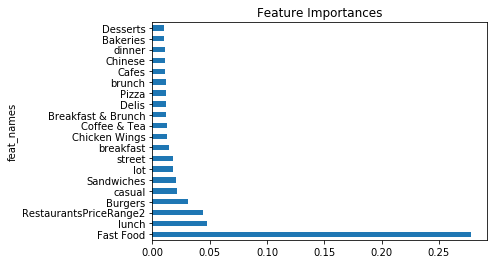

The most important features are:  ['RestaurantsPriceRange2' 'Bakeries' 'Breakfast & Brunch' 'Burgers' 'Cafes'
 'Chicken Wings' 'Chinese' 'Coffee & Tea' 'Delis' 'Desserts' 'Fast Food'
 'Pizza' 'Sandwiches' 'casual' 'lot' 'street' 'breakfast' 'brunch' 'dinner'
 'lunch']


In [32]:
# Let's look at feature importances for regressor
r_feat_index = list(np.where(regr.feature_importances_ > .01)[0])
r_feat_vals = regr.feature_importances_[r_feat_index]
r_feat_names = X.columns.values[r_feat_index]
regr_df = pd.DataFrame({
    'feat_names': r_feat_names,
    'feat_index': r_feat_index,
    'feat_vals': r_feat_vals
})
regr_df.sort_values(by="feat_vals",ascending=False,inplace=True)
print('The most important features are:  ' + str(regr_df['feat_names'].values))
regr_df.set_index('feat_names',inplace=True)
class_graph = (regr_df['feat_vals']
 .plot.barh()
 .set_title('Feature Importances')
)
plt.show()
print('The most important features are:  ' + str(r_feat_names))

In [33]:
corr_feats = list(clf_df.index.values)
corr_feats.append('stars')
corr_df = expanded_rest_df[corr_feats]

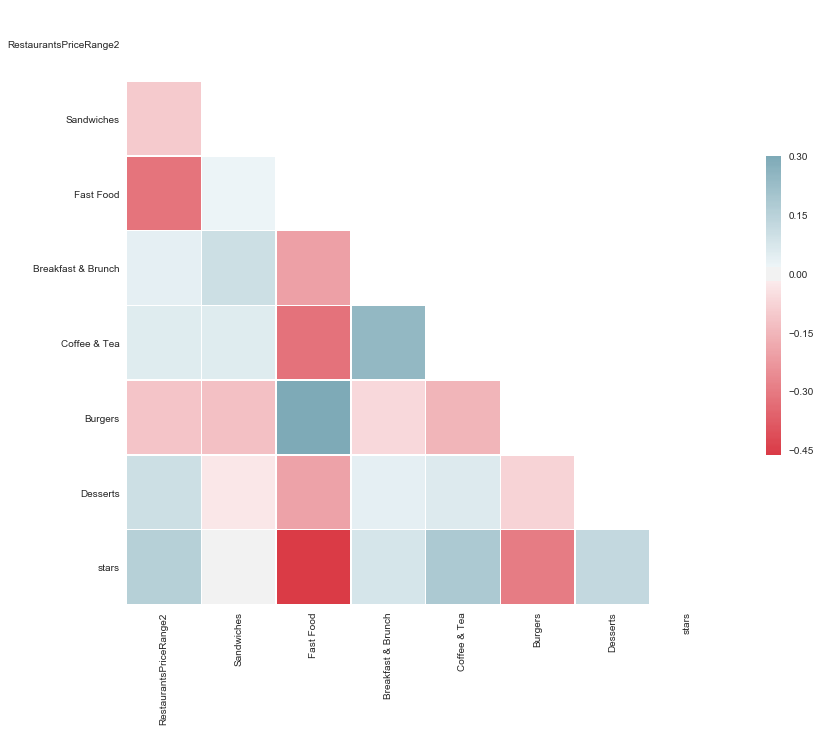

In [34]:
'''
Visual representation of correlations via correlation table.  Use the features that are most important from RF to look at their relationship to 'stars' and any
indication to colinearity.
We will also look at eigenvalues to get a better idea.
'''

sns.set(style="white")
# Compute the correlation matrix
hist_corr = corr_df
corr = hist_corr.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.show()

In [35]:
'''
Doesn't look like any eigenvalues are too close to zero, so we don't have to be too concerned about colinearity when making our final insights.
'''
corr_mat = corr_df.as_matrix().astype(np.float64)
corr_cof = np.corrcoef(corr_mat,rowvar = 0)
w, v = np.linalg.eig(corr_cof)
print(w)
print(abs(w)<0.01)
corr_df.columns.values[:-1]

[ 2.98381773  2.05990023  1.71895703  1.15754167  1.07362829  0.96012921
  0.85428243  0.36694934  0.80211964  0.76137534  0.43869863  0.47214986
  0.50097089  0.6576685   0.63004465  0.56176655]
[False False False False False False False False False False False False
 False False False False]


array(['RestaurantsPriceRange2', 'Sandwiches', 'Fast Food', 'lot',
       'casual', 'breakfast', 'lunch', 'street', 'Breakfast & Brunch',
       'Coffee & Tea', 'dinner', 'Burgers', 'brunch', 'Desserts', 'dessert'], dtype=object)

In [37]:
'''
Since RF didn't work out so well.  Lets try and use GB method.  Gradient Boosting is an iteration of RF that weights subsets of weak learners in order to gather a more complete
subset of weak learners.
'''
from sklearn.ensemble import GradientBoostingRegressor

In [38]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [50]:
'''
Random forest pointed us in the right direction, and we were able to figure out that there was little to no multicolinearity among the top predictors.  In order to further iterate,
I'm going to look at the gradient boosted classifier method, which is more robust with high dimensional data and more impervious to overfitting (which we experienced big time with
the random forest).  I plan on comparing the top feature from GB with RF, and deciding on a set of features to use in an ordinal LAD regression.  From that
regresssion, we will be able to draw out important and actionable insights regarding attributes and their relationship to stars.
'''

print(gbr.score(X_train,y_train))
print(gbr.score(X_test,y_test))
gbr_index = np.where(gbr.feature_importances_ > .01)[0]
gbr_names = list(X.columns.values[gbr_index])

0.375325452131
0.345059615307


In [60]:
gbr_df = X[gbr_names]
gbr_X = gbr_df.as_matrix()

In [61]:
gbr_X_train,gbr_X_test,gbr_y_train,gbr_y_test = train_test_split(gbr_X,y ,test_size=0.3)

In [43]:
'''
The mord python package uses the scikit learn API to create various statistical methods for ordinal data (what we have here).  We will use the the ordinal Least Absolute Deviance
(LAD) regression here.  This regression was primarily chosse because it uses the L1 norm for error, which puts an emphasis on feature selection, but may leave us vulnerable if any
of the predictors happened to be multicollinear.  But since we already confirmed no multicollinearity, we are able use this method confidently.
'''
from mord.regression_based import LAD

In [136]:
lad_train = LAD(verbose=1)
lad_train.fit(gbr_X_train,gbr_y_train)

[LibLinear]

LAD(C=1.0, dual=True, epsilon=0.0, fit_intercept=True, intercept_scaling=1.0,
  loss='epsilon_insensitive', max_iter=1000, random_state=None, tol=0.0001,
  verbose=1)

In [138]:
## Look at coefficient values for 'most important features' determined by Gradient Boosted Linear Regression
lad_coef_train_df = pd.DataFrame({
    'name':gbr_names,
    'value':list(lad_train.coef_)
})
lad_coef_train_df.sort_values(by=['value'],ascending=False,axis=0,inplace=False)

,name,value
24,Poke,0.642320
17,Fish & Chips,0.500114
19,Food Trucks,0.493154
12,Convenience Stores,0.439986
21,Hot Dogs,0.359499
7,Chicken Shop,0.356447
28,Vegan,0.354357
26,Street Vendors,0.297391
25,Specialty Food,0.283819
22,Latin American,0.276287


In [141]:
## Compare our train/test data, we would hope to get similar findings!
lad_test = LAD(verbose=1)
lad_test.fit(gbr_X_test,gbr_y_test)
lad_coef_test_df = pd.DataFrame({
    'name':gbr_names,
    'value':list(lad_test.coef_)
})
lad_coef_test_df.sort_values(by=['value'],ascending=False,axis=0,inplace=False)

[LibLinear]

,name,value
24,Poke,0.620629
7,Chicken Shop,0.497165
22,Latin American,0.492633
19,Food Trucks,0.492115
26,Street Vendors,0.491367
12,Convenience Stores,0.364480
28,Vegan,0.342885
23,Mediterranean,0.254383
30,street,0.245755
17,Fish & Chips,0.239875


In [ ]:
'''
Our analysis returned some interesting findings.  For example, it looks like 'Poke' restaurants have a strong relationship to higher stars.  It also looks like Food Trucks
have been able to experience considerably favorable ratings from users.  As the correlation plot showed, Fast Food restaurants are more likely to receive lower ratings, and it also
looks like Tex-Mex places suffer a similar fate.  Once standard error of these coefficients are calculated, we will be able make claims about our data with greater certainty.
'''

In [ ]:
'''
Next steps: Figure out a way to calculate feature standard errors to determine feature validity (does not come standard with scikit learn libraries).  Add some visualizations and 
some crosstables (pd.crosstab). Then, look at interaction terms between top/all features when predicting stars

Additional Projects w/this dataset:  Use the corpus of user reviews to determine relationship between sentiment/rating.  Could also build recommendation engine from this.
Use text to predict age/gender.  What words/phrases are best at predicting gender/age? (Could use glmnet here)
'''